In [435]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm

In [431]:
# Arima
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [440]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.filterwarnings("ignore")

In [441]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn
%matplotlib inline
seaborn.set
pd.plotting.register_matplotlib_converters()
plt.rcParams['figure.figsize']=(14,8)

In [ ]:
def gerar_janelas(lista, tam):
    '''(np.array, int) -> np.array, np.array'''
    x, y = [], []
    n = len(lista)
    for i in range(n-tam):
        janela = lista[i:i+tam]
        x.append(janela)
        y.append(lista[i+tam])
    return np.array(x), np.array(y)

## Treinando dados de cotações

In [ ]:
# importando o csv das cotações de venda de moeda estrangeira
moeda = "Dolar"
dados_csv = pd.read_csv("datasets/cotacao_%s.csv"%(moeda.split()[0].lower()))
dados_csv.tail()

In [ ]:
# filtra cotacoes de Fechamento
dados_brutos = dados_csv.loc[dados_csv.tipoBoletim == "Fechamento"]
dados_brutos = dados_brutos.reset_index().drop(["tipoBoletim", "index"], axis=1)
dados_brutos.tail()

In [329]:
# Renomear as colunas
dados = dados_brutos.copy()
dados.columns = ["cotacao", "dia"]

# usando apenas o dia e ignorando o horário
dados.dia = pd.to_datetime(dados.dia.str[:10])
dados = dados.set_index("dia")

# convertendo formato da parte decimal
dados.cotacao = pd.to_numeric(dados.cotacao.str.replace(",", "."))

# filtrando períodos
ano_inicial = 2019
dados = dados["2016-07-01":"2017-12-31"]
#dados.head()

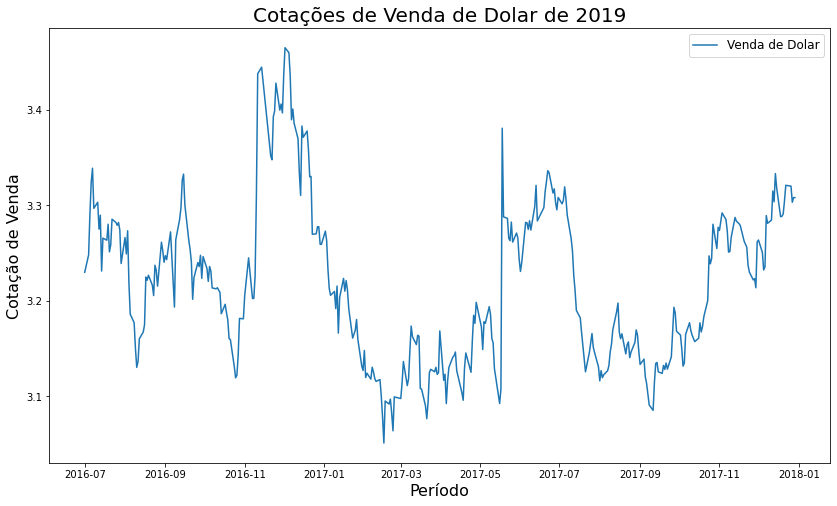

In [330]:
# Exibindo série original
plt.plot(dados, label="Venda de %s"%moeda)
plt.title("Cotações de Venda de %s de %d"%(moeda, ano_inicial), fontsize=20)
plt.xlabel("Período", fontsize=16)
plt.ylabel("Cotação de Venda", fontsize=16)
plt.legend(fontsize=12)
plt.show()

## Treinamento
Treinar respeitando a ordenação temporal

    Validação: Treino | Teste |
    Previsão:  Treino         | Previsão

In [380]:
#train = dados.reset_index().loc[:np.round(dados.shape[0]*train_size), :]
#test = dados.reset_index().loc[train.index.max()+1:, :]
#train = train.set_index("dia")
#test = test.set_index("dia")

# número de dias que serão usados para a comparação
N = 7

# tamanho das janelas de dados
tam_janela = 30

n_total = dados.shape[0]-tam_janela
n_train = dados[:"2017-08-15"].shape[0]-tam_janela

# conferindo
print(n_total, n_train, n_total-n_train)

janelas_x, janelas_y = gerar_janelas(dados.cotacao, tam_janela)
#for i in range(n_train, n_train+N):
#    print(janelas_y[i])

346 253 93


In [389]:
x_train = janelas_x[:n_train].reshape((n_train, tam_janela, 1))
y_train = janelas_y[:n_train]

x_arima = janelas_x[n_train:n_train+N]
x_test = x_arima.reshape((N, tam_janela, 1))
y_test = janelas_y[n_train:n_train+N]

In [462]:
# criar modelo de redes neurais
model = keras.Sequential()
model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='elu', input_shape=(tam_janela, 1)))
model.add(keras.layers.MaxPooling1D(pool_size=3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(30, activation='elu'))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

# treinar modelo
_ = model.fit(x_train, y_train, epochs=25, verbose=0)

# Exibe erro MSE para conjunto de treino
model.evaluate(x_train, y_train)

8/8 [==============================] - 0s 5ms/step - loss: 0.0064


0.00637032650411129

In [464]:
# salvar modelo
model.save("keras_dolar.h5")

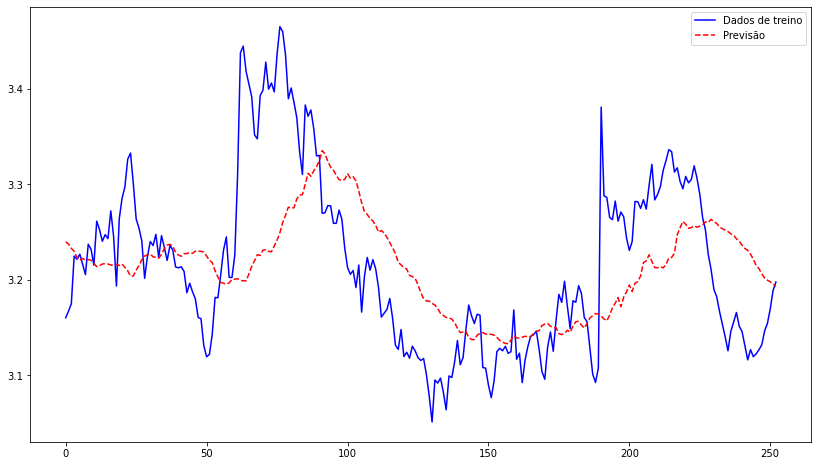

In [463]:
# carregar modelo
#model = keras.models.load_model("keras_dolar.h5")

# Plotando previsões versus real do conjunto de treino
y_train_pred = model.predict(x_train).reshape(-1)

plt.plot(y_train, "b-", label="Dados de treino")
plt.plot(y_train_pred, "r--", label="Previsão")
plt.legend(loc=1)
plt.show()

In [465]:
# erro RMSE = raiz do erro quadrático médio
print("RMSE:", np.sqrt(np.mean((y_train_pred - y_train)**2)))

# erro MAE = erro absoluto médio
print("MAE:", np.mean(np.abs(y_train_pred - y_train)))

RMSE: 0.07981432938219851
MAE: 0.06311824117818839


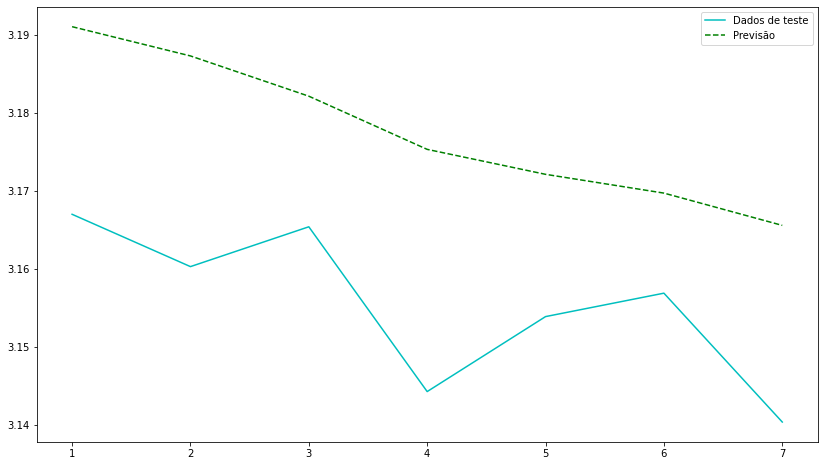

In [466]:
# Plotando previsões versus real do conjunto de teste
y_test_pred = model.predict(x_test).reshape(-1)

# conferindo janelas (ok)
#print(y_train[-N:], y_test, y_test_pred)
#print(janelas_y[n_train-2:n_train+2])

plt.plot(range(1, N+1), y_test, "c-", label="Dados de teste")
plt.plot(range(1, N+1), y_test_pred, "g--", label="Previsão")
plt.legend(loc=0)
plt.show()

## Bloco do Arima

In [428]:
lamb = 0.25
def box(x):
    return (x**lamb - 1)/lamb
    #return np.log(x)
def antibox(x):
    return (x*lamb + 1)**(1/lamb)
    #return np.exp(x)

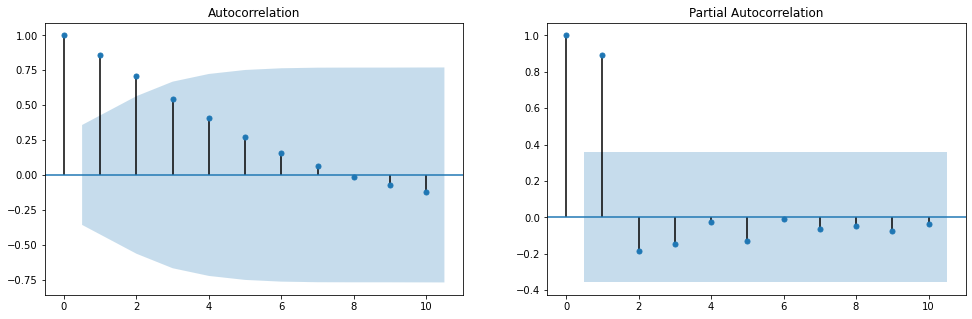

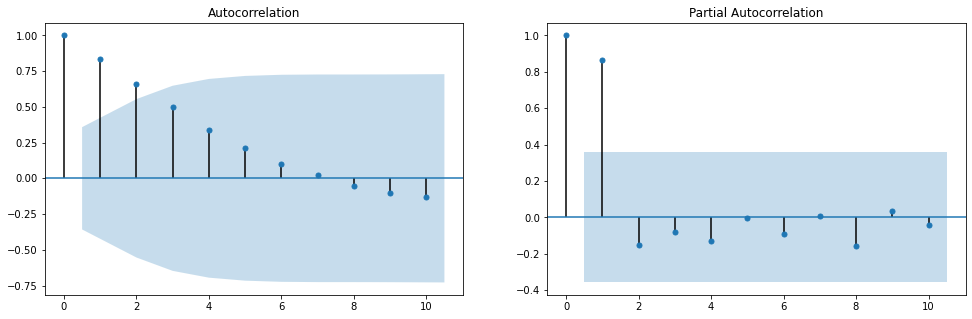

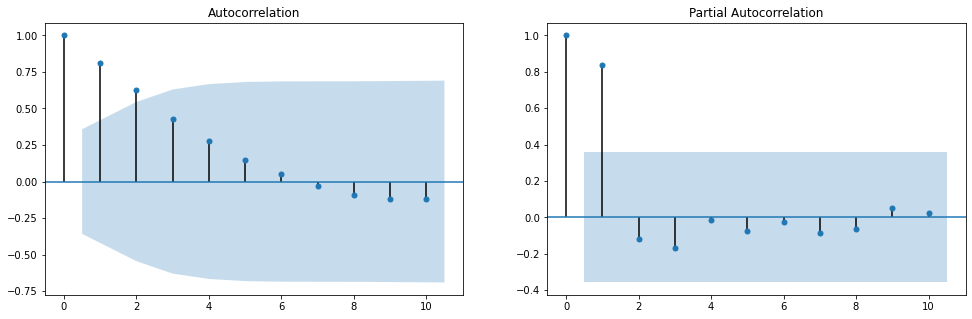

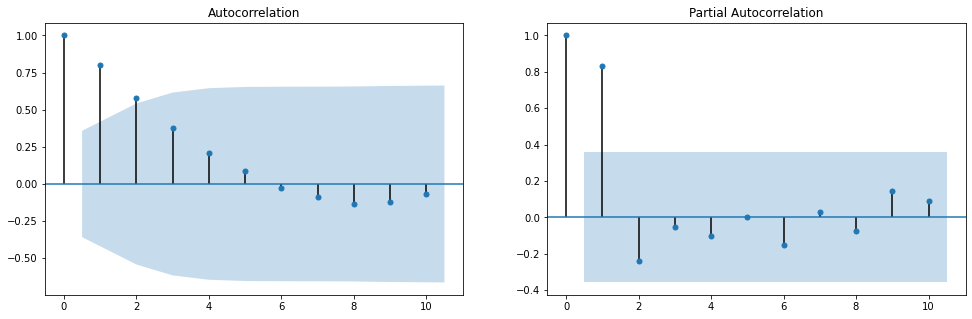

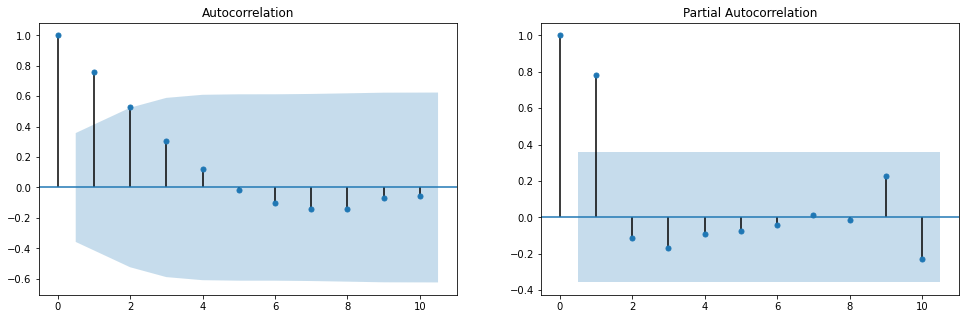

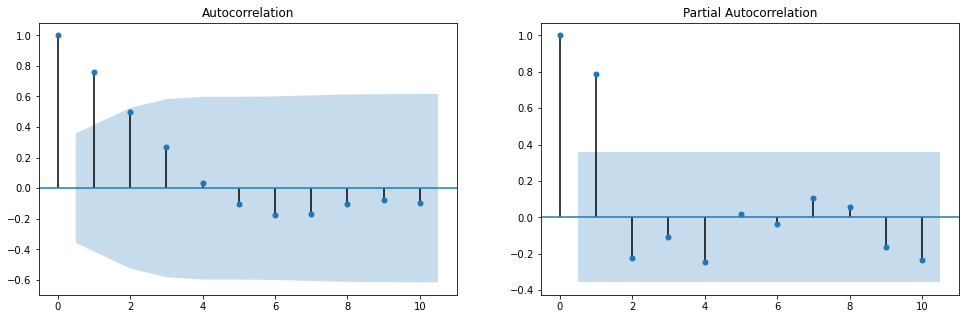

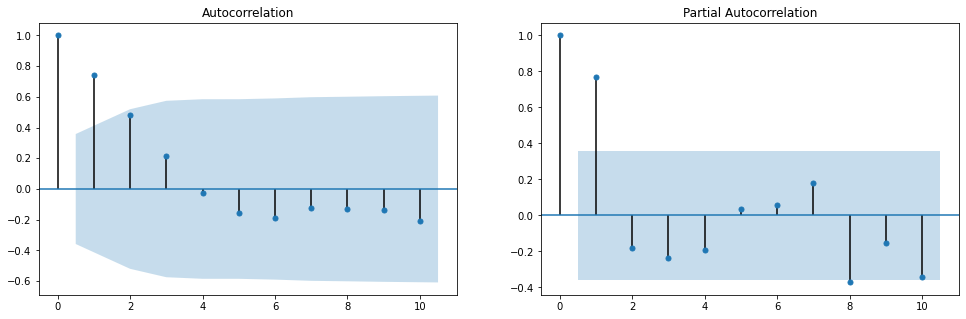

In [412]:
# Autocorrelação
def plotar_autocorrelacao(campo, lags=10):
    '''(np.array, int) -> None'''
    fig, ax = plt.subplots(1, 2, figsize=(16.5, 5))
    acf = plot_acf(campo, lags=lags, ax=ax[0])
    pacf = plot_pacf(campo, lags=lags, ax=ax[1])
    plt.show()

for i in range(N):
    plotar_autocorrelacao(x_arima[i])

### Parâmetros do modelo

    *p é a ordem do componente autoregressiva
    *d é o número de diferenças tomadas na série
    *q é a ordem da componente de médias móveis

In [453]:
p = q = range(0, 4)
d = [0]
pdq = list(itertools.product(p, d, q))[1:] # ignorando (0, 0, 0)
print(pdq)

[(0, 0, 1), (0, 0, 2), (0, 0, 3), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 0, 3), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 0, 3)]


In [454]:
# construindo uma busca de parâmetros ótimos
best_params = []
best_model = []

for k in range(N):
    params = None
    model = None
    best_aic = float("inf")
    for param in pdq:
        try:
            #mod = sm.tsa.ARMA(train.box, order=param)
            mod = ARIMA(x_arima[k], order=param)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                params = param
                model = mod
            #print("ARIMA%s - AIC:%f"%(param, results.aic))
        except:
            continue

    # Exibindo qual o melhor modelo encontrado
    best_params.append(params)
    best_model.append(model)
    print("ARIMA%s - AIC:%f"%(params, best_aic))

ARIMA(2, 0, 1) - AIC:-177.253216
ARIMA(2, 0, 0) - AIC:-164.854092
ARIMA(2, 0, 0) - AIC:-164.737742
ARIMA(2, 0, 0) - AIC:-167.579878
ARIMA(2, 0, 0) - AIC:-164.198244
ARIMA(2, 0, 0) - AIC:-166.698607
ARIMA(1, 0, 3) - AIC:-168.415216


In [456]:
# Previsões múltiplas
y_arima = []
for k in range(N):
    modelo = best_model[k].fit()
    print(modelo.forecast())
    y_arima.append(modelo.forecast()[0][0])

(array([3.21148327]), array([0.00930375]), array([[3.19324826, 3.22971828]]))
(array([3.15051019]), array([0.01273127]), array([[3.12555735, 3.17546303]]))
(array([3.15840166]), array([0.01283031]), array([[3.13325472, 3.18354861]]))
(array([3.16901709]), array([0.01234999]), array([[3.14481156, 3.19322263]]))
(array([3.13698703]), array([0.01312525]), array([[3.11126202, 3.16271204]]))
(array([3.15886772]), array([0.01274241]), array([[3.13389306, 3.18384238]]))
(array([3.15336909]), array([0.01138085]), array([[3.13106305, 3.17567514]]))


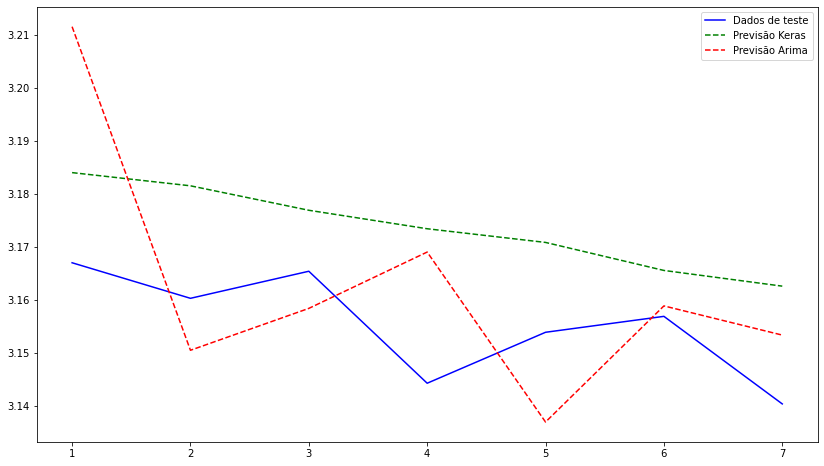

In [457]:
# Plotando tudo junto
plt.plot(range(1, N+1), y_test, "b-", label="Dados de teste")
plt.plot(range(1, N+1), y_test_pred, "g--", label="Previsão Keras")
plt.plot(range(1, N+1), y_arima, "r--", label="Previsão Arima")
plt.legend(loc=0)
plt.show()

In [471]:
# erro RMSE = raiz do erro quadrático médio
print("RMSE Keras: %.6f" %np.sqrt(np.mean((y_test_pred - y_test)**2)))
print("RMSE Arima: %.6f" %np.sqrt(np.mean((y_arima - y_test)**2)))

# erro MAE = erro absoluto médio
print(" MAE Keras: %.6f" %np.mean(np.abs(y_test_pred - y_test)))
print(" MAE Arima: %.6f" %np.mean(np.abs(y_arima - y_test)))

RMSE Keras: 0.022917
RMSE Arima: 0.021356
 MAE Keras: 0.022135
 MAE Arima: 0.016834
